<a href="https://colab.research.google.com/github/aksh-ay06/BRFSS/blob/main/BRFSS2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Can county-level air pollution improve prediction of self-reported cancer prevalence in BRFSS?

In [ ]:
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

In [ ]:

from pathlib import Path
import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats  # was "ss" → use conventional alias
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)

from sklearn.metrics import (
    auc,
    average_precision_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import optuna
from xgboost import XGBClassifier


SEED: int = 42
N_JOBS: int = -1  # use all cores; set to os.cpu_count() - 1 if you want to keep the UI snappy


os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)


sns.set_theme(context="notebook", style="whitegrid")

# Warnings: silence only the noisy-but-safe ones
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
try:
    import optuna.logging as _optuna_log
    _optuna_log.set_verbosity(_optuna_log.WARNING)
except Exception:
    pass


In [ ]:
from pathlib import Path


IS_COLAB = False
try:
    import google.colab  # type: ignore
    IS_COLAB = True
except Exception:
    pass

if IS_COLAB:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    DATA_DIR = Path("/content/drive/MyDrive/BRFSS/2023")
else:
    DATA_DIR = Path("data/raw/BRFSS/2023")

DATA_PATH = DATA_DIR / "BRFSS2023.csv"
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Data file not found at: {DATA_PATH.resolve()}")


read_kwargs = dict(low_memory=False)
try:
    df = pd.read_csv(DATA_PATH, engine="pyarrow", dtype_backend="pyarrow", **read_kwargs)
except Exception:

    df = pd.read_csv(DATA_PATH, **read_kwargs)

print(f"Loaded {len(df):,} rows × {len(df.columns)} cols from {DATA_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 433,323 rows × 350 cols from /content/drive/MyDrive/BRFSS/2023/BRFSS2023.csv


In [ ]:
PARQUET_PATH = DATA_PATH.with_suffix(".parquet")
if PARQUET_PATH.exists():
    df = pd.read_parquet(PARQUET_PATH)
else:
    df = pd.read_csv(DATA_PATH, engine="pyarrow", dtype_backend="pyarrow")
    df.to_parquet(PARQUET_PATH, index=False)


In [ ]:
possible_id_cols = [
    c for c in df.columns
    if c.lower() in {"seqno", "_seqno", "x_seqno", "id", "_id"}
    or c.lower().endswith("id")
    or "seq" in c.lower()
]

id_col = next((c for c in possible_id_cols if df[c].is_unique), None)

n0 = len(df)
if id_col:
    dupe_mask = df.duplicated(subset=id_col, keep="first")
    df = df.loc[~dupe_mask].reset_index(drop=True)
    print(f"Removed {dupe_mask.sum():,} duplicate rows based on '{id_col}'.")
else:
    dupe_mask = df.duplicated(keep="first")
    df = df.loc[~dupe_mask].reset_index(drop=True)
    print(f"Removed {dupe_mask.sum():,} exact duplicate rows (full-row match).")

print(f"Now: {len(df):,} rows × {df.shape[1]} cols")
display(df.head())


Removed 0 exact duplicate rows (full-row match).
Now: 433,323 rows × 350 cols


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
0,1,1,3012023,3,1,2023,1100,2023000001,2023000001,1,...,0,1,0,1,2,2,2,1,1,9
1,1,1,1062023,1,6,2023,1100,2023000002,2023000002,1,...,0,1,0,1,1,1,2,1,1,9
2,1,1,3082023,3,8,2023,1100,2023000003,2023000003,1,...,0,1,0,1,1,1,2,1,1,9
3,1,1,3062023,3,6,2023,1100,2023000004,2023000004,1,...,0,1,0,1,1,1,1,1,1,9
4,1,1,1062023,1,6,2023,1100,2023000005,2023000005,1,...,7,1,47,1,2,1,2,1,1,2


In [ ]:
selected_columns = [
    "_STATE","_LLCPWT","_PSU","CHCOCNC1", "MARITAL", "DEAF", "BLIND", "DECIDE",
    "DIFFWALK", "DIFFDRES", "DIFFALON","LSATISFY", "EMTSUPRT",
    "SDHFOOD1", "SDHBILLS", "SDHUTILS", "SDHTRNSP", "SDHSTRE1",
    "MARJSMOK", "MARJEAT", "MARJVAPE", "MARJDAB", "MARJOTHR",
    "_METSTAT", "_URBSTAT", "_PHYS14D", "_MENT14D", "_HLTHPL1",
    "_TOTINDA","_MICHD", "_ASTHMS1", "_DRDXAR2", "_RACEPRV",
    "_SEX","_AGE_G","HTIN4", "WTKG3", "_BMI5CAT",
    "_RFBMI5", "_CHLDCNT", "_EDUCAG", "_INCOMG1","_RFSMOK3",
    "_CURECI2", "LCSNUMCG", "_RFBING6", "_DRNKWK2", "_RFDRHV8"
]
missing = [c for c in selected_columns if c not in df.columns]
if missing:
    raise KeyError(f"Columns not found in df: {missing}")

df_new = df[selected_columns].copy()

In [ ]:
cat_cols = [
    "_STATE", "CHCOCNC1", "MARITAL", "DEAF", "BLIND", "DECIDE",
    "DIFFWALK", "DIFFDRES", "DIFFALON", "LSATISFY", "EMTSUPRT",
    "SDHFOOD1", "SDHBILLS", "SDHUTILS", "SDHTRNSP", "SDHSTRE1",
    "MARJSMOK", "MARJEAT", "MARJVAPE", "MARJDAB", "MARJOTHR",
    "_METSTAT", "_URBSTAT", "_PHYS14D", "_MENT14D", "_HLTHPL1",
    "_TOTINDA", "_MICHD", "_ASTHMS1", "_DRDXAR2", "_RACEPRV",
    "_SEX","_AGE_G", "_BMI5CAT", "_RFBMI5",
    "_EDUCAG", "_INCOMG1", "_RFSMOK3", "_CURECI2", "_CHLDCNT",
    "_RFBING6", "_RFDRHV8"
]
numeric_cols = ["HTIN4", "WTKG3", "LCSNUMCG", "_DRNKWK2"]

ordinal_vars = [
    "LSATISFY","EMTSUPRT","SDHFOOD1","SDHSTRE1","_PHYS14D",
    "_MENT14D","_ASTHMS1","_AGE_G","_EDUCAG","_INCOMG1","_BMI5CAT"
]
nominal_vars = [c for c in cat_cols if c not in ordinal_vars]


In [ ]:
from pandas import NA

variable_mappings = {
    "_STATE": {
        1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
        8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District of Columbia",
        12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois",
        18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana",
        23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan",
        27: "Minnesota", 28: "Mississippi", 29: "Missouri", 30: "Montana",
        31: "Nebraska", 32: "Nevada", 33: "New Hampshire", 34: "New Jersey",
        35: "New Mexico", 36: "New York", 37: "North Carolina", 38: "North Dakota",
        39: "Ohio", 40: "Oklahoma", 41: "Oregon", 42: "Pennsylvania",
        44: "Rhode Island", 45: "South Carolina", 46: "South Dakota",
        47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont", 51: "Virginia",
        53: "Washington", 54: "West Virginia", 55: "Wisconsin", 56: "Wyoming",
        66: "Guam", 72: "Puerto Rico", 78: "Virgin Islands"
    },
    "CHCOCNC1": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "MARITAL": {1: "Married", 2: "Divorced", 3: "Widowed", 4: "Separated",
                5: "Never married", 6: "A member of a couple", 9: NA},
    "DEAF": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "BLIND": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "DECIDE": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "DIFFWALK": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "DIFFDRES": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "DIFFALON": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "SDHBILLS": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "SDHUTILS": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "SDHTRNSP": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "MARJSMOK": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "MARJEAT": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "MARJVAPE": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "MARJDAB": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "MARJOTHR": {1: "Yes", 2: "No", 7: NA, 9: NA},
    "_METSTAT": {1: "Metropolitan area", 2: "Nonmetropolitan area", 9: NA},
    "_URBSTAT": {1: "Urban", 2: "Rural", 9: NA},
    "_HLTHPL1": {1: "Has some form of insurance", 2: "No insurance", 9: NA},
    "_TOTINDA": {1: "Had physical activity", 2: "No physical activity (30d)", 9: NA},
    "_MICHD": {1: "MI or CHD", 2: "No MI/CHD"},
    "_DRDXAR2": {1: "Arthritis dx", 2: "No arthritis dx"},
    "_RACEPRV": {1: "White Only", 2: "Black Only", 3: "American Indian Only",
                 4: "Asian Only", 5: "Native Hawaiian Only", 6: "Other Race Only",
                 7: "Multiracial", 8: "Hispanic Only"},
    "_SEX": {1: "Male", 2: "Female", 7: NA, 9: NA},
    "_RFSMOK3": {1: "No", 2: "Yes", 9: NA},
    "_CURECI2": {1: "Not using e-cigs", 2: "Current e-cig user", 9: NA},
    "_RFBMI5": {1: "No", 2: "Yes", 9: NA},
    "_RFDRHV8": {1: "No", 2: "Yes", 9: NA},
    "_RFBING6": {1: "No", 2: "Yes", 9: NA},
    "_CHLDCNT": {1: "No child", 2: "One child", 3: "Two children", 4: "Three children",
                 5: "Four children", 6: "Five or more", 9: NA},
}

In [ ]:
def map_codes_to_labels(s: pd.Series, mapping: dict) -> pd.Series:
    s_i = pd.to_numeric(s, errors="coerce").astype("Int64")
    out = s_i.map(mapping)
    return out.astype("category")

for col, mapping in variable_mappings.items():
    if col in df_new.columns:
        df_new[col] = map_codes_to_labels(df_new[col], mapping)


In [ ]:
unhealthy_days_categories = ["0 days", "1–13 days", "14+ days"]
bins = [-np.inf, 0, 13, np.inf]
for col in ["_PHYS14D", "_MENT14D"]:
    if col in df_new.columns:
        vals = pd.to_numeric(df_new[col], errors="coerce")
        df_new[col] = pd.Categorical(
            pd.cut(vals, bins=bins, labels=unhealthy_days_categories, right=True),
            categories=unhealthy_days_categories,
            ordered=True
        )

In [ ]:
ordinal_mappings = {
    "LSATISFY": (["Very satisfied", "Satisfied", "Dissatisfied", "Very dissatisfied"],
                 {1: "Very satisfied", 2: "Satisfied", 3: "Dissatisfied", 4: "Very dissatisfied"}),
    "EMTSUPRT": (["Always", "Usually", "Sometimes", "Never"],
                 {1: "Always", 2: "Usually", 3: "Sometimes", 4: "Never"}),
    "SDHFOOD1": (["Often", "Sometimes", "Never"],
                 {1: "Often", 2: "Sometimes", 3: "Never"}),
    "SDHSTRE1": (["Always", "Usually", "Sometimes", "Never"],
                 {1: "Always", 2: "Usually", 3: "Sometimes", 4: "Never"}),
    "_ASTHMS1": (["Current", "Former", "Never"],
                 {1: "Current", 2: "Former", 3: "Never"}),
    "_AGE_G":   (["18–24", "25–34", "35–44", "45–54", "55–64", "65+"],
                 {1: "18–24", 2: "25–34", 3: "35–44", 4: "45–54", 5: "55–64", 6: "65+"}),
    "_EDUCAG":  (["No HS", "HS Grad", "Some College", "College Grad"],
                 {1: "No HS", 2: "HS Grad", 3: "Some College", 4: "College Grad"}),
    "_INCOMG1": (["<15k", "15k–<25k", "25k–<35k", "35k–<50k", "50k–<75k", "75k+"],
                 {1: "<15k", 2: "15k–<25k", 3: "25k–<35k", 4: "35k–<50k", 5: "50k–<75k", 6: "75k+"}),
    "_BMI5CAT": (["Underweight", "Normal", "Overweight", "Obese"],
                 {1: "Underweight", 2: "Normal", 3: "Overweight", 4: "Obese"}),
}

for var, (cats, value_map) in ordinal_mappings.items():
    if var in df_new.columns:
        # map codes → labels (if not already)
        if not pd.api.types.is_categorical_dtype(df_new[var]):
            df_new[var] = map_codes_to_labels(df_new[var], value_map)
        # enforce ordering
        df_new[var] = df_new[var].astype(pd.CategoricalDtype(categories=cats, ordered=True))

/tmp/ipython-input-1412898865.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_new[var]):
/tmp/ipython-input-1412898865.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_new[var]):
/tmp/ipython-input-1412898865.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_new[var]):
/tmp/ipython-input-1412898865.py:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_new[var]):
/tmp/ipython-input-1412898865.py:26:

In [ ]:
unexpected_nulls = {c: int(df_new[c].isna().sum()) for c in cat_cols if c in df_new.columns}
print("Null counts (categoricals):", {k: v for k, v in unexpected_nulls.items() if v > 0})
print(f"df_new shape: {df_new.shape}")

Null counts (categoricals): {'CHCOCNC1': 2337, 'MARITAL': 4289, 'DEAF': 14792, 'BLIND': 15710, 'DECIDE': 18128, 'DIFFWALK': 17850, 'DIFFDRES': 17676, 'DIFFALON': 19400, 'LSATISFY': 209050, 'EMTSUPRT': 218512, 'SDHFOOD1': 407107, 'SDHBILLS': 209499, 'SDHUTILS': 209528, 'SDHTRNSP': 209787, 'SDHSTRE1': 295986, 'MARJSMOK': 421902, 'MARJEAT': 421908, 'MARJVAPE': 421923, 'MARJDAB': 421975, 'MARJOTHR': 421975, '_METSTAT': 8323, '_URBSTAT': 8323, '_HLTHPL1': 18674, '_TOTINDA': 1251, '_MICHD': 4585, '_ASTHMS1': 3642, '_DRDXAR2': 2560, '_RACEPRV': 86, '_BMI5CAT': 40535, '_RFBMI5': 40535, '_EDUCAG': 2325, '_INCOMG1': 113393, '_RFSMOK3': 23062, '_CURECI2': 23251, '_CHLDCNT': 9086, '_RFBING6': 33409, '_RFDRHV8': 32825}
df_new shape: (433323, 48)


In [ ]:
max_missing = 0.90
miss_rate = df_new[nominal_vars + ordinal_vars].isna().mean().sort_values(ascending=False)
to_drop = miss_rate[miss_rate > max_missing].index.tolist()
print("Dropping ultra-sparse categoricals:", to_drop)

nominal_vars = [c for c in nominal_vars if c not in to_drop]
ordinal_vars = [c for c in ordinal_vars if c not in to_drop]


Dropping ultra-sparse categoricals: ['MARJDAB', 'MARJOTHR', 'MARJVAPE', 'MARJEAT', 'MARJSMOK', 'SDHFOOD1']


In [ ]:
TARGET = "CHCOCNC1"

mask = df_new[TARGET].notna()
y = (df_new.loc[mask, TARGET] == "Yes").astype(int)


if "_LLCPWT" in df_new.columns:
    w = pd.to_numeric(df_new.loc[mask, "_LLCPWT"], errors="coerce").fillna(0.0)
    w = w.clip(lower=0.0)
    w = w / (w.mean() if w.mean() > 0 else 1.0)
else:
    w = pd.Series(np.ones(mask.sum()), index=df_new.loc[mask].index, dtype="float")

drop_cols = [c for c in [TARGET, "_LLCPWT", "_PSU", "_STSTR"] if c in df_new.columns]
X = df_new.loc[mask].drop(columns=drop_cols)


def _make_groups_series(df_full: pd.DataFrame, mask: pd.Series, X_like: pd.DataFrame) -> pd.Series:
    if "_PSU" not in df_full.columns:
        return pd.Series(["UNGROUPED"]*len(X_like), index=X_like.index, dtype="category")
    psu = pd.to_numeric(df_full.loc[mask, "_PSU"], errors="coerce").astype("Int64")
    if "_STSTR" in df_full.columns:
        st  = pd.to_numeric(df_full.loc[mask, "_STSTR"], errors="coerce").astype("Int64")
        g = (st.astype(str) + "_" + psu.astype(str))
    else:
        g = psu.astype(str)
    g = pd.Series(g.values, index=df_full.loc[mask].index, name="group")
    g = g.reindex(X_like.index).fillna("MISSING").astype("category")
    return g

groups_all = _make_groups_series(df_new, mask, X)


from sklearn.model_selection import StratifiedGroupKFold

sgkf_outer = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
for tr_idx, te_idx in sgkf_outer.split(X, y, groups=groups_all):
    X_trainval, X_test = X.iloc[tr_idx], X.iloc[te_idx]
    y_trainval, y_test = y.iloc[tr_idx], y.iloc[te_idx]
    w_trainval, w_test = w.iloc[tr_idx], w.iloc[te_idx]
    groups_trainval = groups_all.iloc[tr_idx]
    break

sgkf_inner = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=SEED+1)
for tr_idx, va_idx in sgkf_inner.split(X_trainval, y_trainval, groups=groups_trainval):
    X_train, X_valid = X_trainval.iloc[tr_idx], X_trainval.iloc[va_idx]
    y_train, y_valid = y_trainval.iloc[tr_idx], y_trainval.iloc[va_idx]
    w_train, w_valid = w_trainval.iloc[tr_idx], w_trainval.iloc[va_idx]
    groups_train = groups_trainval.iloc[tr_idx]
    groups_valid = groups_trainval.iloc[va_idx]
    break

print("Shapes:", {"train":X_train.shape, "valid":X_valid.shape, "test":X_test.shape})
print("Unique groups:", {"train":groups_train.nunique(), "valid":groups_valid.nunique(), "test":groups_all.loc[X_test.index].nunique()})

Shapes: {'train': (259113, 45), 'valid': (85760, 45), 'test': (86113, 45)}
Unique groups: {'train': 15858, 'valid': 5277, 'test': 5265}


In [ ]:

nominal_cols = [c for c in X_train.columns if c in set(nominal_vars)]
ordinal_cols = [c for c in X_train.columns if c in set(ordinal_vars)]
numeric_cols_present = [c for c in X_train.columns if c in set(numeric_cols)]

from pandas.api.types import CategoricalDtype # Import CategoricalDtype
from sklearn.preprocessing import StandardScaler # Import StandardScaler

def _ord_cats(col: str):
    dt = X_train[col].dtype
    if isinstance(dt, CategoricalDtype) and X_train[col].cat.ordered:
        return list(X_train[col].cat.categories)
    # fallback to explicit mapping
    return ordinal_mappings[col][0] if col in ordinal_mappings else sorted(X_train[col].dropna().unique().tolist())

ordinal_categories = [_ord_cats(c) for c in ordinal_cols]


try:
    OHE_TREE = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    OHE_TREE = OneHotEncoder(handle_unknown="ignore", sparse=False)


try:
    OHE_LR = OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=0.01, drop="first", sparse_output=False)
except TypeError:
    OHE_LR = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)

cat_imp = SimpleImputer(strategy="constant", fill_value="Unknown")
num_imp = SimpleImputer(strategy="median", add_indicator=True)

ord_enc = OrdinalEncoder(
    categories=ordinal_categories,
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-1
)


preprocess_tree = ColumnTransformer(
    transformers=[
        ("ord", ord_enc, ordinal_cols),
        ("ohe_nom", Pipeline([("imp", cat_imp), ("ohe", OHE_TREE)]), nominal_cols),
        ("num", num_imp, numeric_cols_present),
    ],
    remainder="drop",
)


preprocess_linear = ColumnTransformer(
    transformers=[
        ("nom", Pipeline([("imp", cat_imp), ("ohe", OHE_LR)]), nominal_cols),
        ("ord", Pipeline([("imp", cat_imp), ("ohe", OHE_LR)]), ordinal_cols),
        ("num", Pipeline([("imp", num_imp), ("sc", StandardScaler())]), numeric_cols_present),
    ],
    remainder="drop",
)

In [ ]:
def cv_score_weighted(model, X, y, w, cv, groups=None, scoring="average_precision"):
    scores = []
    splitter = cv
    if isinstance(cv, int):
        splitter = StratifiedGroupKFold(n_splits=cv, shuffle=True, random_state=SEED)
    for tr_idx, va_idx in splitter.split(X, y, groups=groups):
        Xt, Xv = X.iloc[tr_idx], X.iloc[va_idx]
        yt, yv = y.iloc[tr_idx], y.iloc[va_idx]
        wt, wv = w.iloc[tr_idx], w.iloc[va_idx]
        m = Pipeline(model.steps)  # clone-like
        m.fit(Xt, yt, **{"clf__sample_weight": wt})
        p = m.predict_proba(Xv)[:, 1]
        if scoring == "average_precision":
            s = average_precision_score(yv, p, sample_weight=wv)
        elif scoring == "roc_auc":
            s = roc_auc_score(yv, p, sample_weight=wv)
        else:
            raise ValueError("Unsupported scoring")
        scores.append(float(s))
    return float(np.mean(scores)), float(np.std(scores))


In [ ]:
logreg = Pipeline([
    ("prep", preprocess_linear),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

xgb = Pipeline([
    ("prep", preprocess_tree),
    ("clf", XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=N_JOBS,
        eval_metric="logloss",
    ))
])

n_splits = min(5, int(pd.Series(groups_train).nunique()))
cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
print("CV splits:", n_splits)

lr_cv_ap_mean, lr_cv_ap_std = cv_score_weighted(logreg, X_train, y_train, w_train, cv, groups=groups_train, scoring="average_precision")
lr_cv_roc_mean, lr_cv_roc_std = cv_score_weighted(logreg, X_train, y_train, w_train, cv, groups=groups_train, scoring="roc_auc")
print(f"LogReg (grp-weighted) CV  AUPRC: {lr_cv_ap_mean:.3f}±{lr_cv_ap_std:.3f} | ROC-AUC: {lr_cv_roc_mean:.3f}±{lr_cv_roc_std:.3f}")

xgb_cv_ap_mean, xgb_cv_ap_std = cv_score_weighted(xgb, X_train, y_train, w_train, cv, groups=groups_train, scoring="average_precision")
xgb_cv_roc_mean, xgb_roc_std = cv_score_weighted(xgb, X_train, y_train, w_train, cv, groups=groups_train, scoring="roc_auc")
print(f"XGB    (grp-weighted) CV  AUPRC: {xgb_cv_ap_mean:.3f}±{xgb_cv_ap_std:.3f} | ROC-AUC: {xgb_cv_roc_mean:.3f}±{xgb_roc_std:.3f}")


logreg.fit(X_train, y_train, **{"clf__sample_weight": w_train})
xgb.fit(X_train, y_train, **{"clf__sample_weight": w_train})

p_valid_lr  = logreg.predict_proba(X_valid)[:, 1]
p_valid_xgb = xgb.predict_proba(X_valid)[:, 1]


pi_w_train = float((w_train[y_train == 1]).sum() / w_train.sum())
pi_w_valid = float((w_valid[y_valid == 1]).sum() / w_valid.sum())
pi_w_test  = float((w_test [y_test  == 1]).sum() / w_test .sum())
print(f"Weighted prevalence — train:{pi_w_train:.3%} | valid:{pi_w_valid:.3%} | test:{pi_w_test:.3%}")


CV splits: 5
LogReg (grp-weighted) CV  AUPRC: 0.214±0.010 | ROC-AUC: 0.790±0.006
XGB    (grp-weighted) CV  AUPRC: 0.212±0.006 | ROC-AUC: 0.789±0.004
Weighted prevalence — train:7.916% | valid:7.994% | test:7.867%


Chosen thresholds @~0.75 recall: {'logreg': 0.09357864982806736, 'xgb': 0.08444619923830032} | infos: {'precision': 0.1879955924091583, 'recall': 0.7500764316421618} {'precision': 0.17863840818626542, 'recall': 0.7502734262120986}

—— LogReg (weighted) ——
thr=0.093579 | pos_rate=50.689% | p[min, med, max]=[0.0014, 0.0958, 0.6428]
AUPRC: 0.217 | ROC-AUC: 0.799 | Precision@thr: 0.184 | Recall@thr: 0.741
              precision    recall  f1-score   support

           0      0.970     0.719     0.826 78933.43443998402
           1      0.184     0.741     0.295 6739.813450041225

    accuracy                          0.721 85673.24789002525
   macro avg      0.577     0.730     0.560 85673.24789002525
weighted avg      0.908     0.721     0.784 85673.24789002525



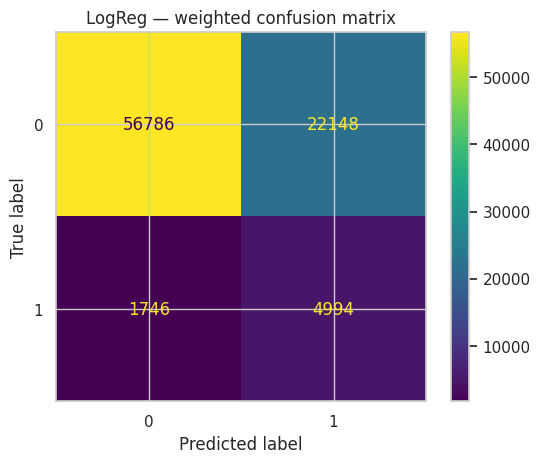


—— XGB (weighted) ——
thr=0.084446 | pos_rate=53.776% | p[min, med, max]=[0.0002, 0.0972, 0.7990]
AUPRC: 0.215 | ROC-AUC: 0.799 | Precision@thr: 0.180 | Recall@thr: 0.773
              precision    recall  f1-score   support

           0      0.973     0.700     0.814 78933.43443998402
           1      0.180     0.773     0.292 6739.813450041225

    accuracy                          0.706 85673.24789002525
   macro avg      0.577     0.737     0.553 85673.24789002525
weighted avg      0.911     0.706     0.773 85673.24789002525



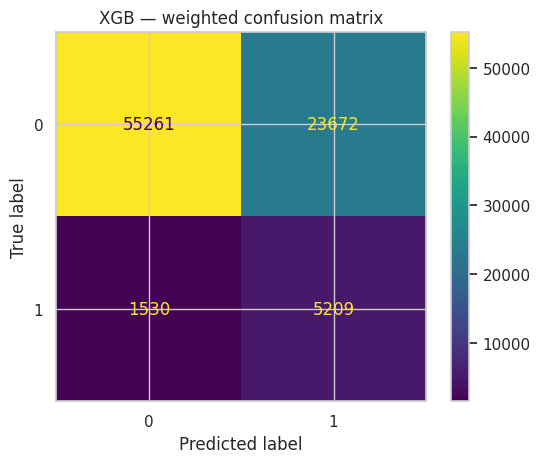

,Model,AUPRC (test),Lift vs base,ROC-AUC (test),Precision@thr,Recall@thr,Weighted base (test)
0,LogReg,0.217,2.75,0.799,0.184,0.741,0.079
1,XGB,0.215,2.74,0.799,0.180,0.773,0.079


In [ ]:
def pick_threshold_weighted(y_true, y_proba, w, target_recall=0.75, eps=1e-12):
    dfp = pd.DataFrame({"y": y_true.values, "p": y_proba, "w": w.values}).sort_values("p", ascending=False).reset_index(drop=True)
    tp_cum = (dfp["y"] * dfp["w"]).cumsum()
    w_cum  = dfp["w"].cumsum()
    pos_w  = (dfp["y"] * dfp["w"]).sum() + eps
    recall    = tp_cum / pos_w
    precision = tp_cum / (w_cum + eps)
    idx = np.where(recall >= target_recall)[0]
    if len(idx):
        i = int(idx[0])
    else:
        f1 = 2 * precision * recall / (precision + recall + eps)
        i = int(np.nanargmax(f1))
    return float(dfp.loc[i, "p"]), {"precision": float(precision[i]), "recall": float(recall[i])}

def threshold_at_precision_weighted(y_true, y_proba, w, min_precision=0.30, eps=1e-12):
    dfp = pd.DataFrame({"y": y_true.values, "p": y_proba, "w": w.values}).sort_values("p", ascending=False)
    tp_cum = (dfp["y"] * dfp["w"]).cumsum()
    w_cum  = dfp["w"].cumsum()
    precision = tp_cum / (w_cum + eps)
    ok = np.where(precision.values >= min_precision)[0]
    return float(dfp.iloc[int(ok[0])]["p"]) if len(ok) else 0.5

def evaluate_weighted(model, X_te, y_te, w_te, thr, name="model", cm_decimals=0):
    p = model.predict_proba(X_te)[:, 1]
    yhat = (p >= thr).astype(int)

    ap   = average_precision_score(y_te, p, sample_weight=w_te)
    roc  = roc_auc_score(y_te, p, sample_weight=w_te)
    prec = precision_score(y_te, yhat, sample_weight=w_te, zero_division=0)
    rec  = recall_score(y_te, yhat, sample_weight=w_te, zero_division=0)

    pos_rate = float(yhat.mean())
    p_min, p_med, p_max = float(np.min(p)), float(np.median(p)), float(np.max(p))

    print(f"\n—— {name} (weighted) ——")
    print(f"thr={thr:.6f} | pos_rate={pos_rate:.3%} | p[min, med, max]=[{p_min:.4f}, {p_med:.4f}, {p_max:.4f}]")
    print(f"AUPRC: {ap:.3f} | ROC-AUC: {roc:.3f} | Precision@thr: {prec:.3f} | Recall@thr: {rec:.3f}")
    print(classification_report(y_te, yhat, sample_weight=w_te, digits=3))

    cm = np.round(confusion_matrix(y_te, yhat, sample_weight=w_te), 0)
    ConfusionMatrixDisplay(cm).plot(values_format=".0f")
    plt.title(f"{name} — weighted confusion matrix")
    plt.show()
    return p, ap, roc, prec, rec


thr_lr,  info_lr  = pick_threshold_weighted(y_valid, p_valid_lr,  w_valid, target_recall=0.75)
thr_xgb, info_xgb = pick_threshold_weighted(y_valid, p_valid_xgb, w_valid, target_recall=0.75)
print("Chosen thresholds @~0.75 recall:", {"logreg": thr_lr, "xgb": thr_xgb}, "| infos:", info_lr, info_xgb)


p_test_lr,  ap_lr,  roc_lr,  prec_lr,  rec_lr  = evaluate_weighted(logreg, X_test, y_test, w_test, thr_lr,  name="LogReg")
p_test_xgb, ap_xgb, roc_xgb, prec_xgb, rec_xgb = evaluate_weighted(xgb,    X_test, y_test, w_test, thr_xgb, name="XGB")


summary = pd.DataFrame([
    {"Model":"LogReg","AUPRC (test)":round(ap_lr,3),"Lift vs base":round(ap_lr/max(pi_w_test,1e-12),2),
     "ROC-AUC (test)":round(roc_lr,3),"Precision@thr":round(prec_lr,3),"Recall@thr":round(rec_lr,3),"Weighted base (test)":round(pi_w_test,3)},
    {"Model":"XGB","AUPRC (test)":round(ap_xgb,3),"Lift vs base":round(ap_xgb/max(pi_w_test,1e-12),2),
     "ROC-AUC (test)":round(roc_xgb,3),"Precision@thr":round(prec_xgb,3),"Recall@thr":round(rec_xgb,3),"Weighted base (test)":round(pi_w_test,3)}
])
display(summary)


In [ ]:
def get_feature_names_from_ct(ct: ColumnTransformer) -> np.ndarray:
    try:
        return ct.get_feature_names_out()
    except Exception:
        names = []
        for name, trans, cols in ct.transformers_:
            if name == "remainder": continue
            if hasattr(trans, "get_feature_names_out"):
                try:
                    fn = trans.get_feature_names_out(cols)
                    names.extend(fn)
                    continue
                except Exception:
                    pass
            if isinstance(trans, Pipeline):
                last = trans.steps[-1][1]
                if hasattr(last, "get_feature_names_out"):
                    try:
                        fn = last.get_feature_names_out(cols)
                        names.extend(fn); continue
                    except Exception:
                        pass
            if isinstance(cols, (list, tuple, np.ndarray)):
                names.extend([f"{name}__{c}" for c in cols])
            else:
                names.append(f"{name}__{cols}")
        return np.array(names, dtype=object)

def top_logreg_coeffs(model: Pipeline, k: int = 25) -> pd.DataFrame:
    prep = model.named_steps["prep"]; clf = model.named_steps["clf"]
    names = get_feature_names_from_ct(prep); coefs = clf.coef_.ravel()
    dfc = pd.DataFrame({"feature": names, "coef": coefs, "abs_coef": np.abs(coefs), "odds_ratio": np.exp(coefs)})
    top_pos = dfc.sort_values("coef", ascending=False).head(k)
    top_neg = dfc.sort_values("coef", ascending=True).head(k)
    return pd.concat([top_pos, top_neg], axis=0, ignore_index=True)

def top_xgb_importances(model: Pipeline, k: int = 25) -> pd.DataFrame:
    prep = model.named_steps["prep"]; clf = model.named_steps["clf"]
    names = get_feature_names_from_ct(prep); imps = getattr(clf, "feature_importances_", None)
    if imps is None: return pd.DataFrame(columns=["feature","importance"])
    dfi = pd.DataFrame({"feature": names, "importance": imps})
    return dfi.sort_values("importance", ascending=False).head(k)

def clean_feature_labels(df):
    out = df.copy()
    if "feature" in out.columns:
        out["feature"] = (out["feature"]
                          .str.replace("_nan", "_Unknown", regex=False)
                          .str.replace("ohe_nom__", "", regex=False)
                          .str.replace("ohe_ord__", "", regex=False)
                          .str.replace("ord__", "", regex=False)
                          .str.replace("num__", "", regex=False))
    return out

display(clean_feature_labels(top_logreg_coeffs(logreg, k=10)))
display(clean_feature_labels(top_xgb_importances(xgb, k=10)))


,feature,coef,abs_coef,odds_ratio
0,_AGE_G_65+,2.767916,2.767916,15.925405
1,_AGE_G_55–64,2.137773,2.137773,8.480530
2,_AGE_G_45–54,1.660010,1.660010,5.259363
3,_AGE_G_35–44,1.008659,1.008659,2.741921
4,nom__DIFFWALK_Unknown,0.303659,0.303659,1.354806
5,nom__DECIDE_Yes,0.231394,0.231394,1.260356
6,_AGE_G_25–34,0.218812,0.218812,1.244598
7,nom__DEAF_Yes,0.213284,0.213284,1.237736
8,nom___RACEPRV_White Only,0.199682,0.199682,1.221014
9,_INCOMG1_<15k,0.173392,0.173392,1.189332


,feature,importance
6,_AGE_G,0.107095
112,_DRDXAR2_No arthritis dx,0.030841
122,_RACEPRV_White Only,0.028493
111,_DRDXAR2_Arthritis dx,0.023091
123,_SEX_Female,0.017557
130,_CHLDCNT_No child,0.015293
115,_RACEPRV_Asian Only,0.014732
65,MARITAL_Never married,0.014610
109,_MICHD_No MI/CHD,0.014128
124,_SEX_Male,0.011437


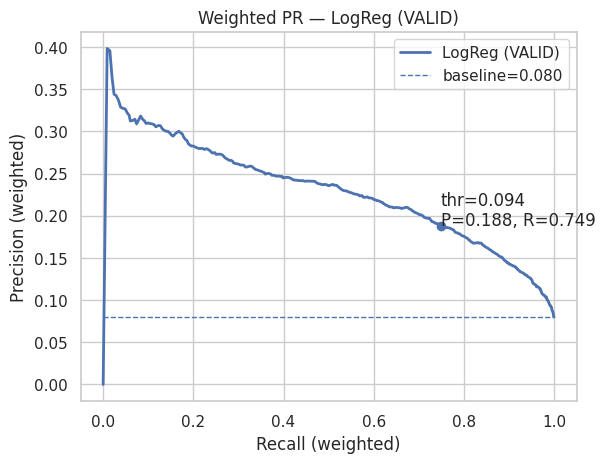

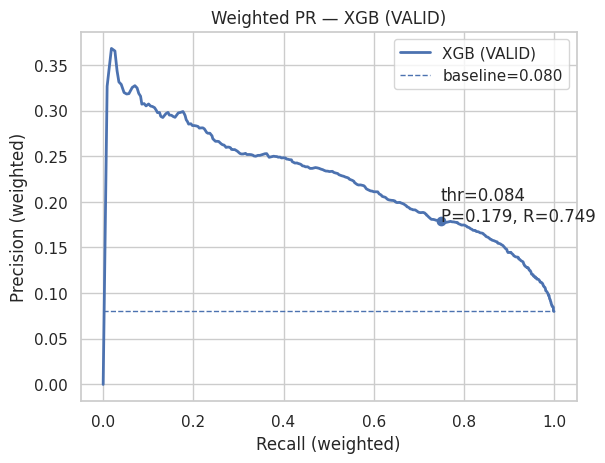

In [ ]:
def weighted_precision_recall_points(y_true, y_proba, w, n=400, eps=1e-12):
    dfp = pd.DataFrame({"y": y_true.values, "p": y_proba, "w": w.values}).sort_values("p", ascending=False)
    tp_cum = (dfp["y"] * dfp["w"]).cumsum()
    w_cum  = dfp["w"].cumsum()
    pos_w  = (dfp["y"] * dfp["w"]).sum() + eps
    recall = (tp_cum / pos_w).to_numpy()
    precision = (tp_cum / (w_cum + eps)).to_numpy()
    thresholds = dfp["p"].to_numpy()
    idx = np.linspace(0, len(thresholds)-1, min(n, len(thresholds))).astype(int)
    return precision[idx], recall[idx], thresholds[idx]

def plot_weighted_pr(y_true, y_proba, w, thr=None, label="model"):
    p, r, t = weighted_precision_recall_points(y_true, y_proba, w)
    plt.figure()
    plt.plot(r, p, lw=2, label=label)
    base = float((w[y_true==1]).sum() / w.sum())
    plt.hlines(base, 0, 1, linestyles="dashed", linewidth=1, label=f"baseline={base:.3f}")
    if thr is not None:
        i = np.argmin(np.abs(t - thr))
        plt.scatter([r[i]], [p[i]])
        plt.annotate(f"thr={thr:.3f}\nP={p[i]:.3f}, R={r[i]:.3f}", (r[i], p[i]))
    plt.xlabel("Recall (weighted)"); plt.ylabel("Precision (weighted)")
    plt.title(f"Weighted PR — {label}"); plt.legend(); plt.show()

plot_weighted_pr(y_valid, p_valid_lr,  w_valid, thr=thr_lr,  label="LogReg (VALID)")
plot_weighted_pr(y_valid, p_valid_xgb, w_valid, thr=thr_xgb, label="XGB (VALID)")
